In [1]:
import pandas as pd                    # Data manipulation
import numpy as np                     # Mathematical operations
import matplotlib.pyplot as plt        # Basic plotting
import seaborn as sns                  # Beautiful plots
import plotly.express as px            # Interactive charts
import plotly.graph_objects as go      # Advanced interactive charts
from plotly.subplots import make_subplots  # Multiple charts in one figure

# Time series specific imports
from prophet import Prophet            # Facebook's forecasting model
from pmdarima import auto_arima        # Automatic ARIMA model
from statsmodels.tsa.seasonal import seasonal_decompose  # Break down time series

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # No line wrapping
plt.style.use('seaborn-v0_8-whitegrid')     # Clean plot style

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
df = pd.read_csv('Sales_Dataset.csv')
# Display first 5 rows to verify data loaded correctly
print("📊 First 5 rows of your data:")
print(df.head())

# Display basic info about the dataset
print("\n📋 Dataset Info:")
print(f"Number of rows: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(f"Column names: {list(df.columns)}")

📊 First 5 rows of your data:
         Date  Gender  Age Product Category  Quantity  Price per Unit  \
0  11/24/2023    Male   34           Beauty         3              50   
1   2/27/2023  Female   26         Clothing         2             500   
2   1/13/2023    Male   50      Electronics         1              30   
3   5/21/2023    Male   37         Clothing         1             500   
4    5/6/2023    Male   30           Beauty         2              50   

   Total Amount  
0           150  
1          1000  
2            30  
3           500  
4           100  

📋 Dataset Info:
Number of rows: 1000
Number of columns: 7
Column names: ['Date', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount']


In [4]:
# This tells us what type of data each column contains

print("🔍 Data Types for Each Column:")
print(df.dtypes)

print("\n📈 Basic Statistics:")
print(df.describe())

print("\n🔢 Non-null counts:")
print(df.info())

🔍 Data Types for Each Column:
Date                object
Gender              object
Age                  int64
Product Category    object
Quantity             int64
Price per Unit       int64
Total Amount         int64
dtype: object

📈 Basic Statistics:
              Age     Quantity  Price per Unit  Total Amount
count  1000.00000  1000.000000     1000.000000   1000.000000
mean     41.39200     2.514000      179.890000    456.000000
std      13.68143     1.132734      189.681356    559.997632
min      18.00000     1.000000       25.000000     25.000000
25%      29.00000     1.000000       30.000000     60.000000
50%      42.00000     3.000000       50.000000    135.000000
75%      53.00000     4.000000      300.000000    900.000000
max      64.00000     4.000000      500.000000   2000.000000

🔢 Non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            ---

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Verify the conversion worked
print("✅ Date column converted to datetime")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Data type: {df['Date'].dtype}")


✅ Date column converted to datetime
Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Data type: datetime64[ns]


In [6]:
# Sort the dataframe by date (oldest to newest)
df = df.sort_values('Date').reset_index(drop=True)

print("✅ Data sorted by date")
print("First date:", df['Date'].iloc[0])
print("Last date:", df['Date'].iloc[-1])


✅ Data sorted by date
First date: 2023-01-01 00:00:00
Last date: 2024-01-01 00:00:00


🔍 Missing Values in Each Column:
Date                0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64

📊 Percentage of Missing Values:
Date                0.0
Gender              0.0
Age                 0.0
Product Category    0.0
Quantity            0.0
Price per Unit      0.0
Total Amount        0.0
dtype: float64


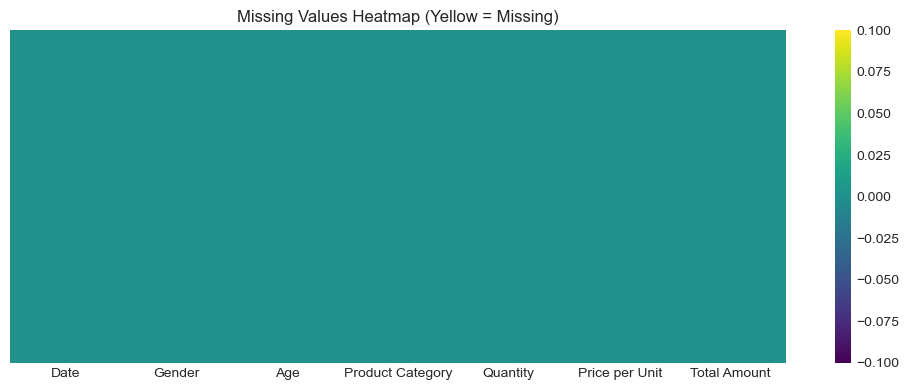

In [7]:
# Check for Missing Values
print("🔍 Missing Values in Each Column:")
print(df.isnull().sum())

print("\n📊 Percentage of Missing Values:")
print((df.isnull().sum() / len(df) * 100).round(2))

# Visualize missing values
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap (Yellow = Missing)')
plt.tight_layout()
plt.show()

In [8]:
# Check for duplicates
duplicates_count = df.duplicated().sum()
print(f"🔍 Number of duplicate rows: {duplicates_count}")

# Remove duplicates if any exist
if duplicates_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"✅ Removed {duplicates_count} duplicate rows")
    print(f"New dataset size: {len(df)} rows")
else:
    print("✅ No duplicates found")

🔍 Number of duplicate rows: 0
✅ No duplicates found


In [9]:
# Extract year, month, day, day of week from date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Create readable day name
df['DayName'] = df['Date'].dt.day_name()
df['MonthName'] = df['Date'].dt.month_name()

# Create a flag for weekend
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print("✅ Time-based features created:")
print(df[['Date', 'Year', 'Month', 'DayName', 'IsWeekend']].head(10))


✅ Time-based features created:
        Date  Year  Month    DayName  IsWeekend
0 2023-01-01  2023      1     Sunday          1
1 2023-01-01  2023      1     Sunday          1
2 2023-01-01  2023      1     Sunday          1
3 2023-01-02  2023      1     Monday          0
4 2023-01-02  2023      1     Monday          0
5 2023-01-02  2023      1     Monday          0
6 2023-01-02  2023      1     Monday          0
7 2023-01-03  2023      1    Tuesday          0
8 2023-01-04  2023      1  Wednesday          0
9 2023-01-04  2023      1  Wednesday          0


In [10]:
# EXPLORATORY DATA ANALYSIS (EDA)
# Create daily sales summary
daily_sales = df.groupby('Date').agg({
    'Total Amount': 'sum',      # Sum of all sales that day
    'Quantity': 'sum',          # Total items sold
    'Age': 'mean',              # Average customer age
}).reset_index()

# Rename columns for clarity
daily_sales.columns = ['Date', 'Daily_Sales', 'Daily_Quantity', 'Avg_Customer_Age']

print("📊 Daily Sales Summary:")
print(daily_sales.head(10))
print(f"\nTotal days in dataset: {len(daily_sales)}")


📊 Daily Sales Summary:
        Date  Daily_Sales  Daily_Quantity  Avg_Customer_Age
0 2023-01-01         3600              10         42.333333
1 2023-01-02         1765              10         34.750000
2 2023-01-03          600               2         26.000000
3 2023-01-04         1240               8         30.333333
4 2023-01-05         1100               5         45.333333
5 2023-01-06          620               5         56.000000
6 2023-01-07          150               6         45.500000
7 2023-01-08          625               3         52.500000
8 2023-01-09          200               4         63.000000
9 2023-01-10          230               5         29.000000

Total days in dataset: 345


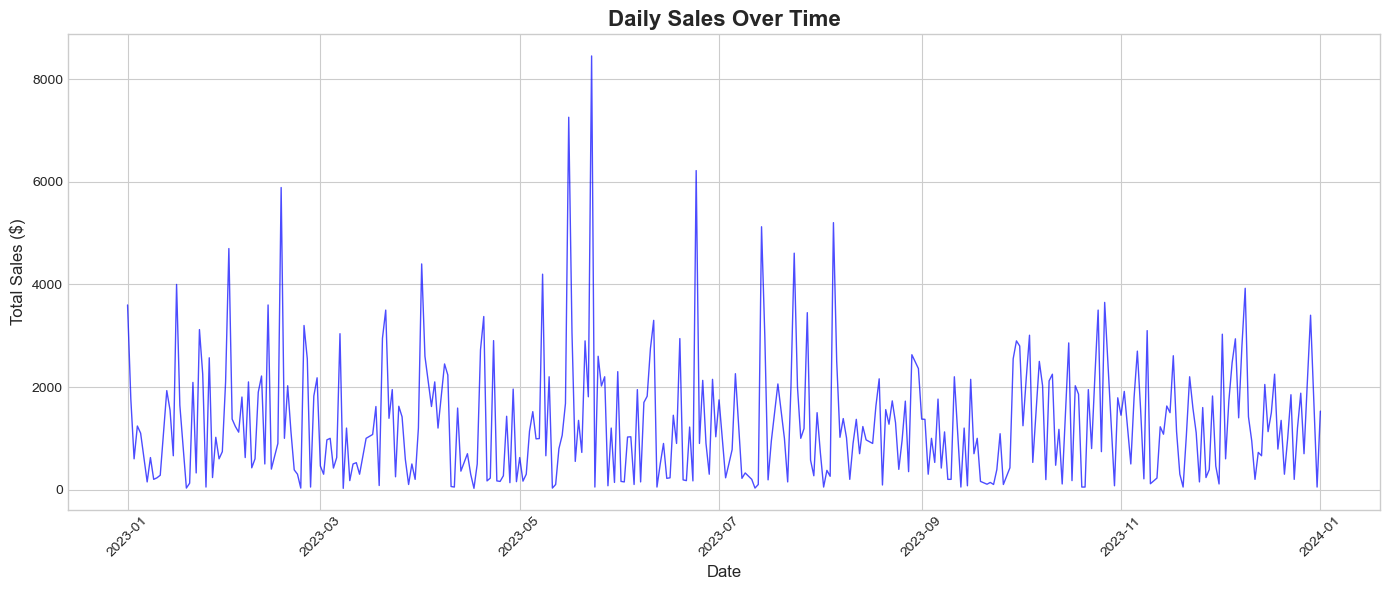

In [11]:
# The most basic but important visualization

plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'], daily_sales['Daily_Sales'], 
         color='blue', linewidth=1, alpha=0.7)
plt.title('Daily Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

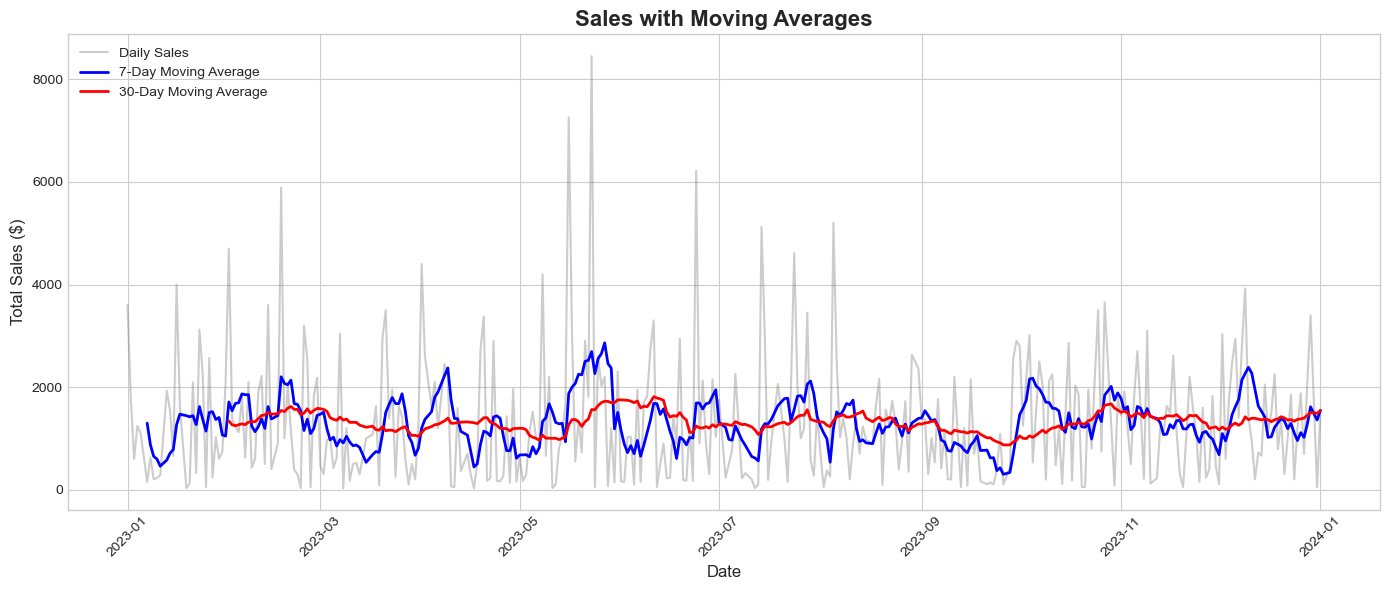

In [12]:
# Calculate moving averages
daily_sales['MA_7'] = daily_sales['Daily_Sales'].rolling(window=7).mean()   # 7-day
daily_sales['MA_30'] = daily_sales['Daily_Sales'].rolling(window=30).mean() # 30-day

# Plot sales with moving averages
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'], daily_sales['Daily_Sales'], 
         label='Daily Sales', alpha=0.4, color='gray')
plt.plot(daily_sales['Date'], daily_sales['MA_7'], 
         label='7-Day Moving Average', color='blue', linewidth=2)
plt.plot(daily_sales['Date'], daily_sales['MA_30'], 
         label='30-Day Moving Average', color='red', linewidth=2)
plt.title('Sales with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


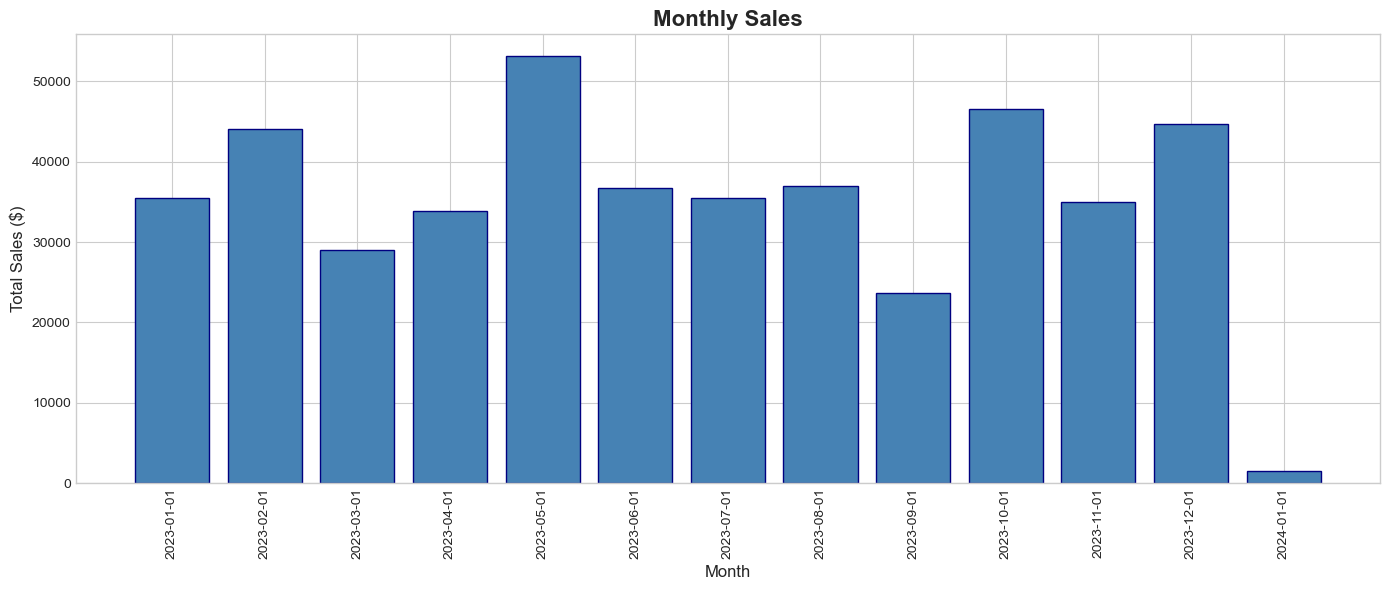

In [13]:
# See which months have highest/lowest sales

monthly_sales = df.groupby(['Year', 'Month'])['Total Amount'].sum().reset_index()
monthly_sales['YearMonth'] = pd.to_datetime(
    monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str)
)

plt.figure(figsize=(14, 6))
plt.bar(monthly_sales['YearMonth'].astype(str), monthly_sales['Total Amount'], 
        color='steelblue', edgecolor='navy')
plt.title('Monthly Sales', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

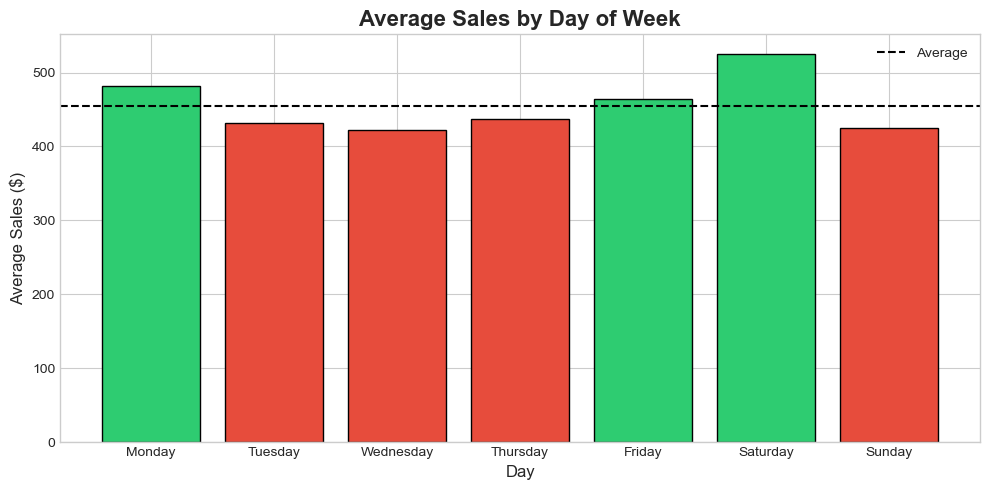

In [14]:
# Which days are busiest?

dow_sales = df.groupby('DayName')['Total Amount'].mean()
# Reorder days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = dow_sales.reindex(day_order)

plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if x >= dow_sales.mean() else '#e74c3c' for x in dow_sales.values]
plt.bar(dow_sales.index, dow_sales.values, color=colors, edgecolor='black')
plt.axhline(y=dow_sales.mean(), color='black', linestyle='--', label='Average')
plt.title('Average Sales by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average Sales ($)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

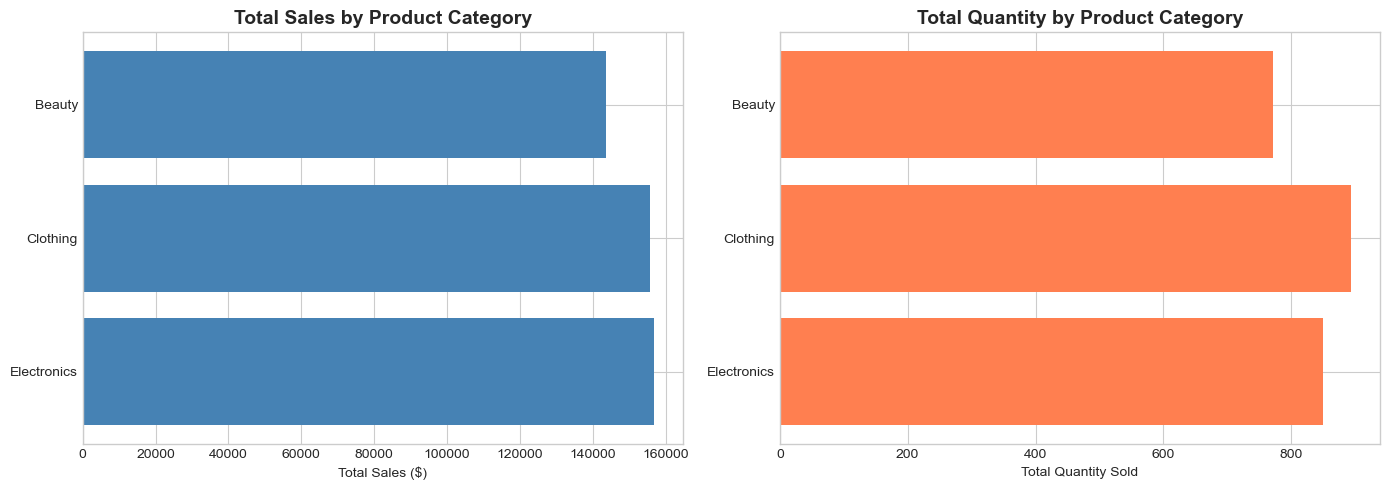

In [15]:
# Which products sell best?

category_sales = df.groupby('Product Category').agg({
    'Total Amount': 'sum',
    'Quantity': 'sum'
}).sort_values('Total Amount', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sales by category
axes[0].barh(category_sales.index, category_sales['Total Amount'], color='steelblue')
axes[0].set_title('Total Sales by Product Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Sales ($)')

# Quantity by category
axes[1].barh(category_sales.index, category_sales['Quantity'], color='coral')
axes[1].set_title('Total Quantity by Product Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Quantity Sold')

plt.tight_layout()
plt.show()


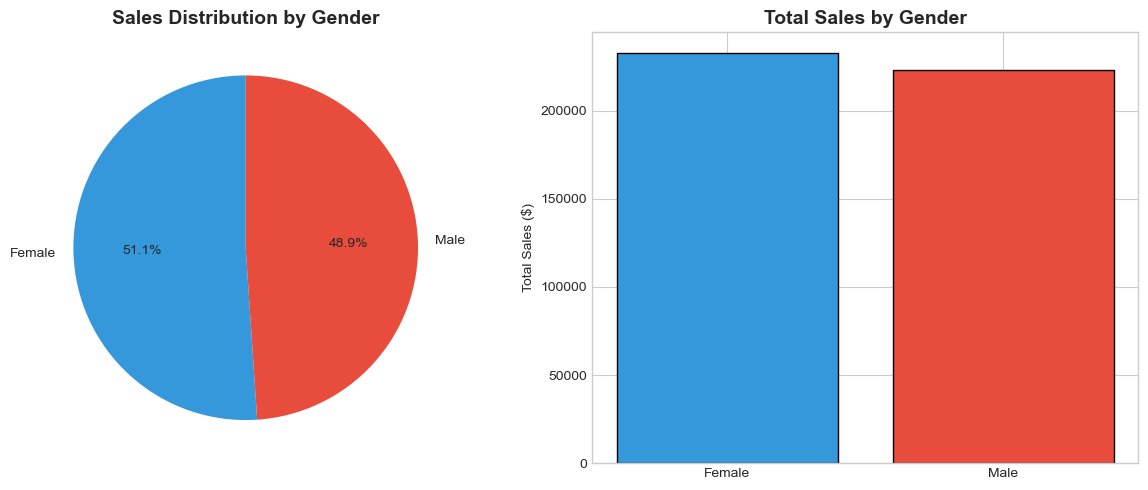

In [16]:
# Sales distribution by gender

gender_sales = df.groupby('Gender')['Total Amount'].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
axes[0].pie(gender_sales.values, labels=gender_sales.index, autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c', '#2ecc71'], startangle=90)
axes[0].set_title('Sales Distribution by Gender', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(gender_sales.index, gender_sales.values, 
            color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].set_title('Total Sales by Gender', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Sales ($)')

plt.tight_layout()
plt.show()


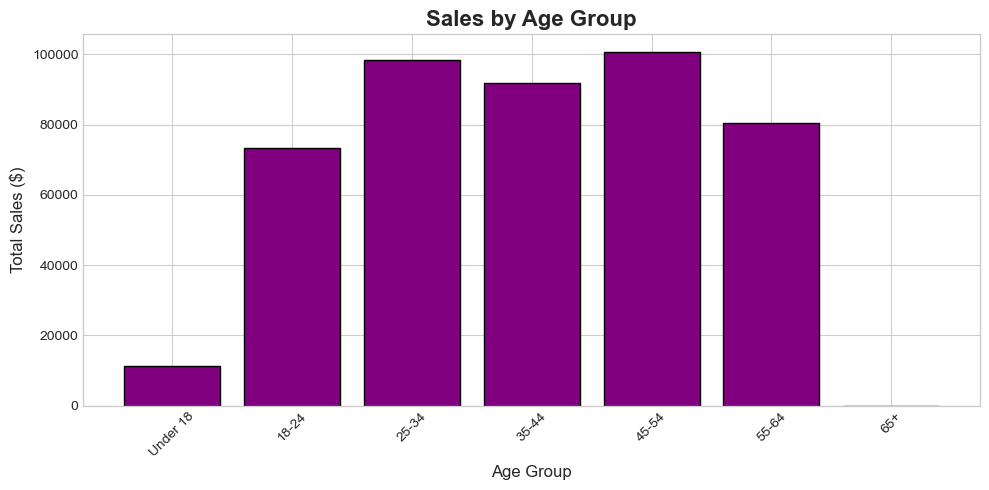

In [17]:
# Create age groups and analyze

# Define age groups
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

age_sales = df.groupby('AgeGroup')['Total Amount'].sum()

plt.figure(figsize=(10, 5))
plt.bar(age_sales.index.astype(str), age_sales.values, color='purple', edgecolor='black')
plt.title('Sales by Age Group', fontsize=16, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

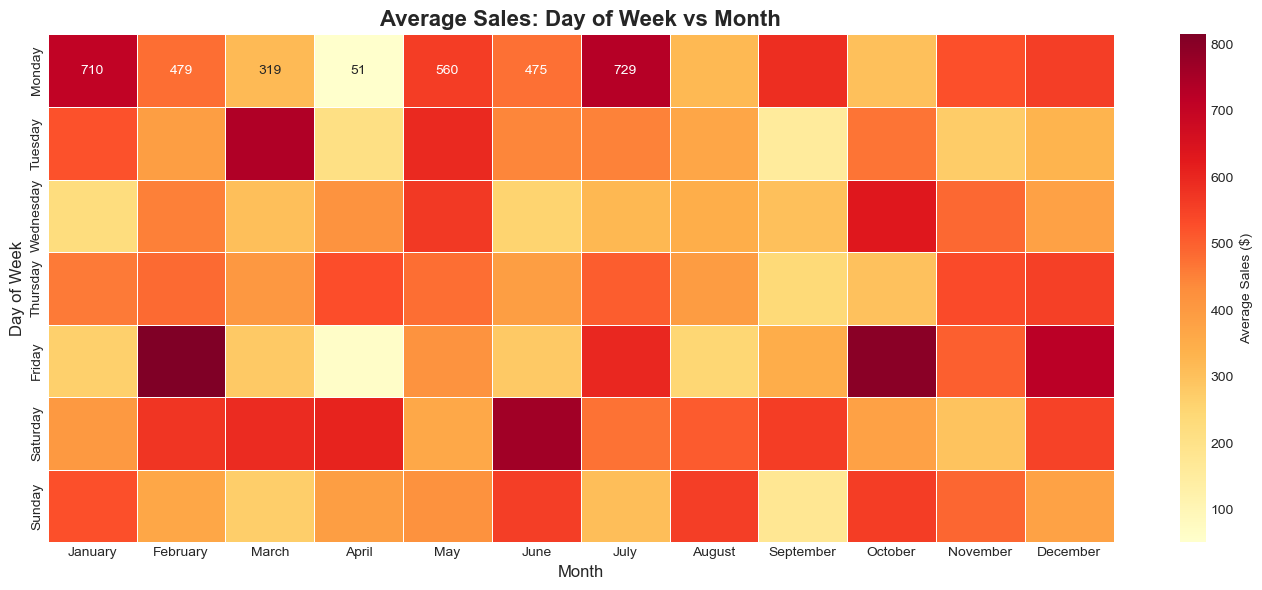

In [18]:
# Visual pattern recognition

# Create pivot table for heatmap
heatmap_data = df.pivot_table(
    values='Total Amount', 
    index='DayName', 
    columns='MonthName', 
    aggfunc='mean'
)

# Reorder rows and columns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Only include months that exist in the data
existing_months = [m for m in month_order if m in heatmap_data.columns]
heatmap_data = heatmap_data.reindex(index=day_order, columns=existing_months)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', 
            linewidths=0.5, cbar_kws={'label': 'Average Sales ($)'})
plt.title('Average Sales: Day of Week vs Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

📊 Outlier Detection Results:
Lower bound: $-2,175.00
Upper bound: $4,425.00
Number of outliers: 8


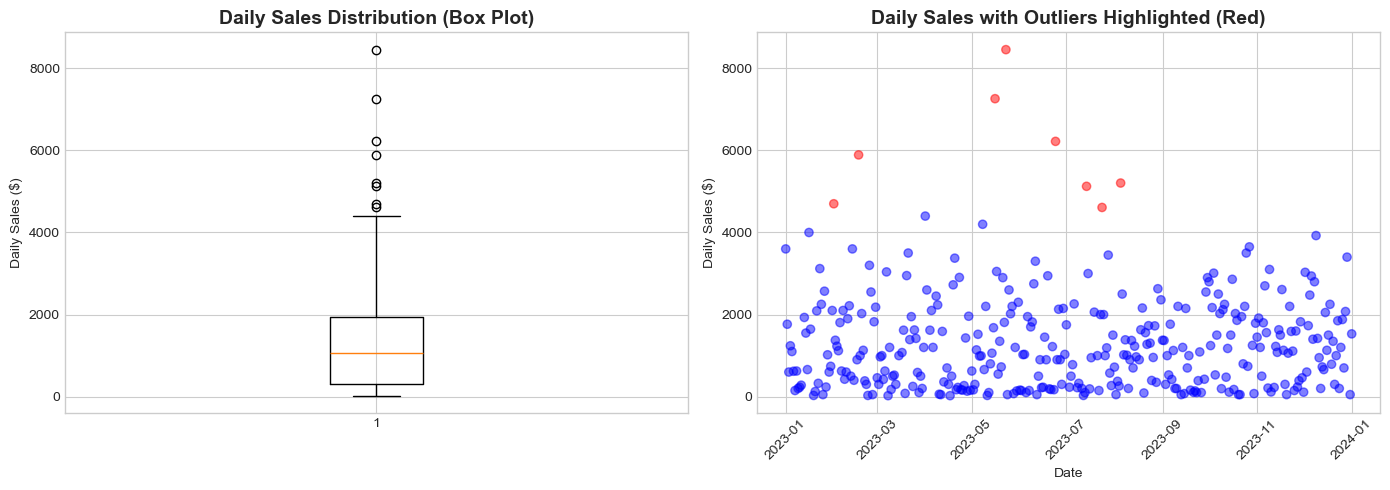

In [19]:
# Identify unusual sales days

# Calculate IQR for outlier detection
Q1 = daily_sales['Daily_Sales'].quantile(0.25)
Q3 = daily_sales['Daily_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
daily_sales['Is_Outlier'] = (
    (daily_sales['Daily_Sales'] < lower_bound) | 
    (daily_sales['Daily_Sales'] > upper_bound)
)

print(f"📊 Outlier Detection Results:")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"Number of outliers: {daily_sales['Is_Outlier'].sum()}")

# Box plot for visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(daily_sales['Daily_Sales'])
axes[0].set_title('Daily Sales Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Daily Sales ($)')

# Scatter plot highlighting outliers
colors = ['red' if x else 'blue' for x in daily_sales['Is_Outlier']]
axes[1].scatter(daily_sales['Date'], daily_sales['Daily_Sales'], c=colors, alpha=0.5)
axes[1].set_title('Daily Sales with Outliers Highlighted (Red)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Sales ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

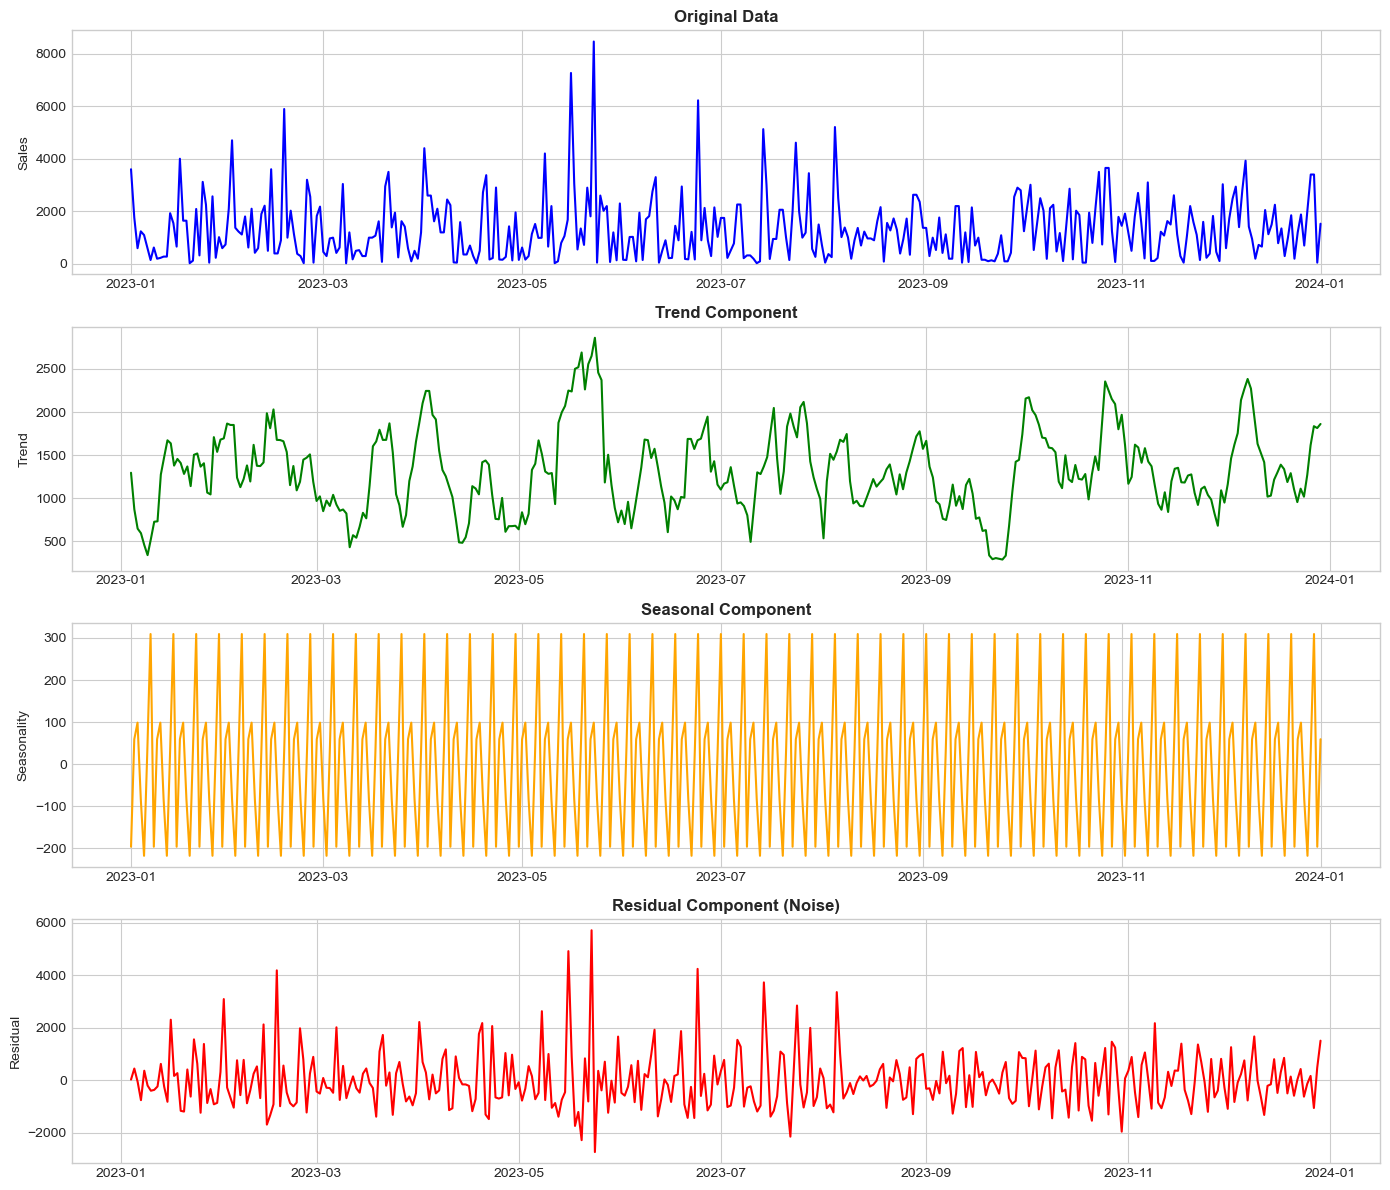

In [21]:
# Ensure no missing dates by resampling
ts_data = daily_sales.set_index('Date')['Daily_Sales'].asfreq('D')
ts_data = ts_data.fillna(method='ffill')  # Forward fill missing values

# Decompose the time series
decomposition = seasonal_decompose(ts_data, model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(decomposition.observed, color='blue')
axes[0].set_title('Original Data', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales')

axes[1].plot(decomposition.trend, color='green')
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')

axes[2].plot(decomposition.seasonal, color='orange')
axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonality')

axes[3].plot(decomposition.resid, color='red')
axes[3].set_title('Residual Component (Noise)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()


In [22]:
# Prepare Data for Prophet
# Create a clean dataframe for Prophet
prophet_df = daily_sales[['Date', 'Daily_Sales']].copy()

# Rename columns to Prophet's required format
prophet_df.columns = ['ds', 'y']

# Make sure dates are datetime
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Remove any rows with NaN values
prophet_df = prophet_df.dropna()

print("📊 Data prepared for Prophet:")
print(prophet_df.head())
print(f"\nTotal records: {len(prophet_df)}")
print(f"Date range: {prophet_df['ds'].min()} to {prophet_df['ds'].max()}")

📊 Data prepared for Prophet:
          ds     y
0 2023-01-01  3600
1 2023-01-02  1765
2 2023-01-03   600
3 2023-01-04  1240
4 2023-01-05  1100

Total records: 345
Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00


In [23]:
# Calculate split point (keep last 30 days for testing)
test_days = 30
split_date = prophet_df['ds'].max() - pd.Timedelta(days=test_days)

# Split the data
train_df = prophet_df[prophet_df['ds'] <= split_date].copy()
test_df = prophet_df[prophet_df['ds'] > split_date].copy()

print(f"📊 Data Split:")
print(f"Training data: {len(train_df)} days ({train_df['ds'].min()} to {train_df['ds'].max()})")
print(f"Testing data: {len(test_df)} days ({test_df['ds'].min()} to {test_df['ds'].max()})")


📊 Data Split:
Training data: 316 days (2023-01-01 00:00:00 to 2023-12-02 00:00:00)
Testing data: 29 days (2023-12-03 00:00:00 to 2024-01-01 00:00:00)


In [24]:
# Initialize the Prophet model with parameters
prophet_model = Prophet(
    yearly_seasonality=True,      # Capture yearly patterns
    weekly_seasonality=True,      # Capture weekly patterns (day of week effects)
    daily_seasonality=False,      # Usually not needed for daily data
    seasonality_mode='multiplicative',  # Good for data with varying amplitude
    changepoint_prior_scale=0.05,  # How flexible the trend is (lower = smoother)
    interval_width=0.95           # 95% confidence interval
)

# Fit (train) the model on training data
print("🔄 Training Prophet model... (this may take a minute)")
prophet_model.fit(train_df)
print("✅ Prophet model trained successfully!")

13:53:37 - cmdstanpy - INFO - Chain [1] start processing


🔄 Training Prophet model... (this may take a minute)


13:53:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model trained successfully!


In [25]:
# Create future dataframe for test period
test_future = prophet_model.make_future_dataframe(periods=test_days, freq='D')

# Generate predictions
test_predictions = prophet_model.predict(test_future)

# Extract only the test period predictions
test_forecast = test_predictions[test_predictions['ds'] > split_date].copy()

print("📊 Predictions generated:")
print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))

📊 Predictions generated:
            ds         yhat   yhat_lower   yhat_upper
316 2023-12-03   930.512983 -1501.821032  3259.040989
317 2023-12-04  1159.185271 -1285.380733  3568.842166
318 2023-12-05  1239.115627 -1022.020044  3442.563407
319 2023-12-06  1137.660012 -1179.142223  3732.482174
320 2023-12-07  1044.446675 -1316.169683  3427.071958
321 2023-12-08  1260.081992 -1127.485609  3600.881599
322 2023-12-09  1570.930868  -729.557312  4016.991427
323 2023-12-10  1263.023447 -1056.773223  3588.182326
324 2023-12-11  1504.104182  -945.812644  3857.060137
325 2023-12-12  1589.057683  -788.380427  3834.139865


In [26]:
# Compare predictions to actual values

# Merge predictions with actual values
evaluation_df = test_df.merge(
    test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    on='ds', 
    how='left'
)

# Calculate error metrics
mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
rmse = np.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat']))
mape = np.mean(np.abs((evaluation_df['y'] - evaluation_df['yhat']) / evaluation_df['y'])) * 100

print("📈 PROPHET MODEL PERFORMANCE")
print("=" * 40)
print(f"MAE (Mean Absolute Error):  ${mae:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"MAPE (Mean Absolute % Error): {mape:.2f}%")
print("=" * 40)

"""
INTERPRETING THE METRICS:
- MAE: On average, predictions are off by $X
- RMSE: Similar to MAE but penalizes large errors more
- MAPE: On average, predictions are off by X% of actual values
  - MAPE < 10%: Excellent
  - MAPE 10-20%: Good
  - MAPE 20-50%: Reasonable
  - MAPE > 50%: Poor
"""

📈 PROPHET MODEL PERFORMANCE
MAE (Mean Absolute Error):  $810.21
RMSE (Root Mean Squared Error): $1,000.27
MAPE (Mean Absolute % Error): 168.09%


'\nINTERPRETING THE METRICS:\n- MAE: On average, predictions are off by $X\n- RMSE: Similar to MAE but penalizes large errors more\n- MAPE: On average, predictions are off by X% of actual values\n  - MAPE < 10%: Excellent\n  - MAPE 10-20%: Good\n  - MAPE 20-50%: Reasonable\n  - MAPE > 50%: Poor\n'

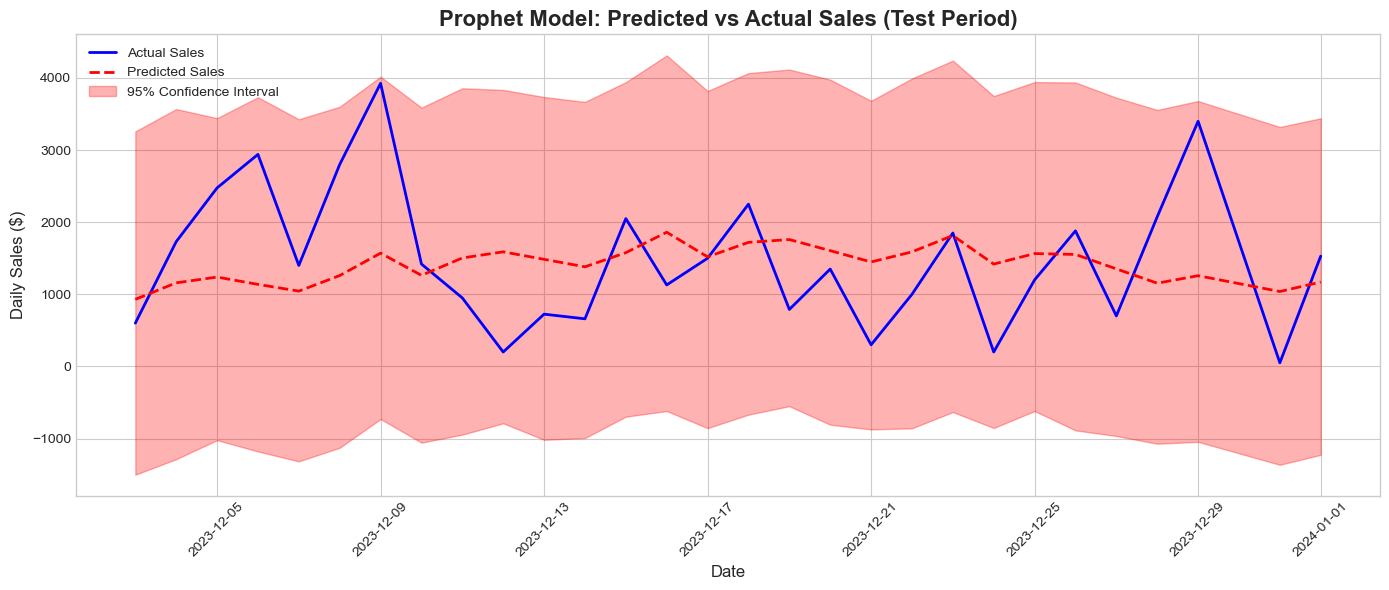

In [27]:
# Visualize Prophet Predictions vs Actual

plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(evaluation_df['ds'], evaluation_df['y'], 
         label='Actual Sales', color='blue', linewidth=2)

# Plot predictions
plt.plot(evaluation_df['ds'], evaluation_df['yhat'], 
         label='Predicted Sales', color='red', linestyle='--', linewidth=2)

# Plot confidence interval
plt.fill_between(evaluation_df['ds'], 
                 evaluation_df['yhat_lower'], 
                 evaluation_df['yhat_upper'],
                 alpha=0.3, color='red', label='95% Confidence Interval')

plt.title('Prophet Model: Predicted vs Actual Sales (Test Period)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


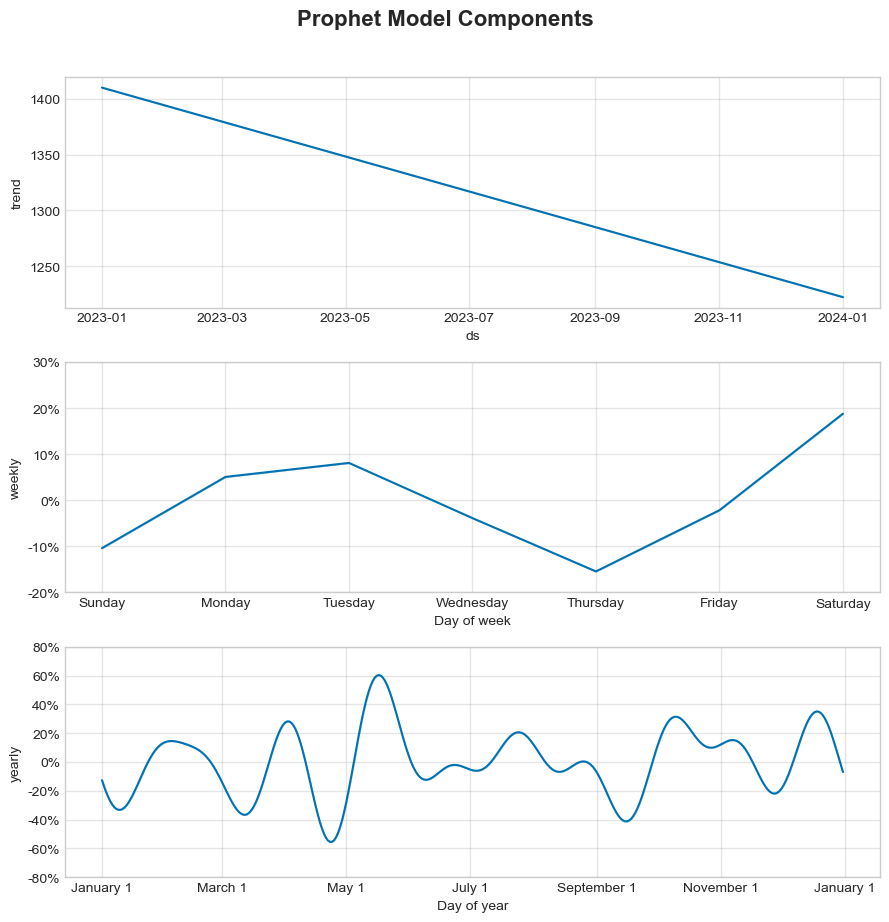

In [28]:
# Visualize what Prophet learned about your data

fig = prophet_model.plot_components(test_predictions)
plt.suptitle('Prophet Model Components', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [29]:
# Prepare Data for ARIMA

# ARIMA needs a time series with datetime index
arima_train = train_df.set_index('ds')['y']
arima_test = test_df.set_index('ds')['y']

print(f"📊 ARIMA Training Data Shape: {arima_train.shape}")
print(f"📊 ARIMA Test Data Shape: {arima_test.shape}")

📊 ARIMA Training Data Shape: (316,)
📊 ARIMA Test Data Shape: (29,)


In [30]:
# Build Auto-ARIMA Model

print("🔄 Finding best ARIMA parameters... (this may take several minutes)")

# Auto-ARIMA automatically searches for best parameters
arima_model = auto_arima(
    arima_train,
    start_p=0, start_q=0,      # Starting values for p and q
    max_p=5, max_q=5,          # Maximum values for p and q
    d=None,                     # Let auto_arima determine d
    seasonal=True,              # Include seasonal component
    m=7,                        # Seasonal period (7 for weekly)
    start_P=0, start_Q=0,       # Seasonal starting values
    max_P=2, max_Q=2,           # Seasonal maximum values
    trace=True,                 # Print search progress
    error_action='ignore',      # Ignore errors
    suppress_warnings=True,     # Hide warnings
    stepwise=True,              # Use stepwise search (faster)
    n_fits=50                   # Maximum models to try
)

print("\n✅ Best ARIMA model found!")
print(arima_model.summary())

🔄 Finding best ARIMA parameters... (this may take several minutes)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5402.659, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5406.002, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5405.860, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5636.561, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=5404.391, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5404.048, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5404.421, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=5404.441, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=5406.410, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7] intercept
Total fit time: 0.855 seconds

✅ Best ARIMA model found!
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observat

In [31]:
# Forecast for the test period
arima_predictions, arima_conf_int = arima_model.predict(
    n_periods=len(arima_test),
    return_conf_int=True,
    alpha=0.05  # 95% confidence interval
)

# Create dataframe with predictions
arima_forecast_df = pd.DataFrame({
    'ds': arima_test.index,
    'y_actual': arima_test.values,
    'yhat': arima_predictions,
    'yhat_lower': arima_conf_int[:, 0],
    'yhat_upper': arima_conf_int[:, 1]
})

print("📊 ARIMA Predictions:")
print(arima_forecast_df.head(10))


📊 ARIMA Predictions:
            ds  y_actual         yhat   yhat_lower   yhat_upper
316 2023-12-03       600  1306.708861 -1124.563858  3737.981579
317 2023-12-04      1730  1306.708861 -1124.563858  3737.981579
318 2023-12-05      2475  1306.708861 -1124.563858  3737.981579
319 2023-12-06      2940  1306.708861 -1124.563858  3737.981579
320 2023-12-07      1400  1306.708861 -1124.563858  3737.981579
321 2023-12-08      2800  1306.708861 -1124.563858  3737.981579
322 2023-12-09      3925  1306.708861 -1124.563858  3737.981579
323 2023-12-10      1420  1306.708861 -1124.563858  3737.981579
324 2023-12-11       950  1306.708861 -1124.563858  3737.981579
325 2023-12-12       200  1306.708861 -1124.563858  3737.981579


In [32]:
# Evaluate ARIMA Model Performance

arima_mae = mean_absolute_error(arima_forecast_df['y_actual'], arima_forecast_df['yhat'])
arima_rmse = np.sqrt(mean_squared_error(arima_forecast_df['y_actual'], arima_forecast_df['yhat']))
arima_mape = np.mean(np.abs((arima_forecast_df['y_actual'] - arima_forecast_df['yhat']) / arima_forecast_df['y_actual'])) * 100

print("\n📈 ARIMA MODEL PERFORMANCE")
print("=" * 40)
print(f"MAE (Mean Absolute Error):  ${arima_mae:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${arima_rmse:,.2f}")
print(f"MAPE (Mean Absolute % Error): {arima_mape:.2f}%")
print("=" * 40)


📈 ARIMA MODEL PERFORMANCE
MAE (Mean Absolute Error):  $763.79
RMSE (Root Mean Squared Error): $976.33
MAPE (Mean Absolute % Error): 173.30%


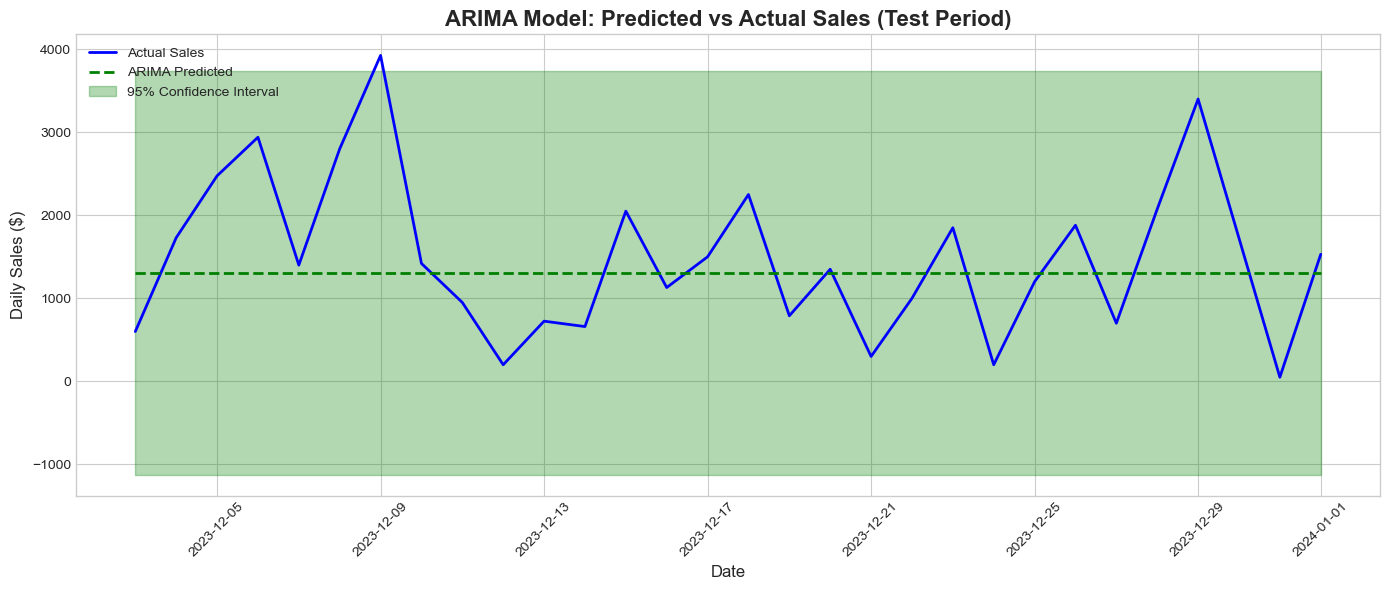

In [33]:
# Visualize ARIMA Predictions vs Actual

plt.figure(figsize=(14, 6))

plt.plot(arima_forecast_df['ds'], arima_forecast_df['y_actual'], 
         label='Actual Sales', color='blue', linewidth=2)
plt.plot(arima_forecast_df['ds'], arima_forecast_df['yhat'], 
         label='ARIMA Predicted', color='green', linestyle='--', linewidth=2)
plt.fill_between(arima_forecast_df['ds'], 
                 arima_forecast_df['yhat_lower'], 
                 arima_forecast_df['yhat_upper'],
                 alpha=0.3, color='green', label='95% Confidence Interval')

plt.title('ARIMA Model: Predicted vs Actual Sales (Test Period)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Generate Future Forecasts with Prophet

# Retrain Prophet on ALL data for final model
print("🔄 Training final Prophet model on all data...")

final_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    interval_width=0.95
)
final_prophet.fit(prophet_df)

# Create future dates for forecasting
forecast_days = 90  # Predict next 90 days

# Generate future dates
future_dates = final_prophet.make_future_dataframe(periods=forecast_days, freq='D')

# Make predictions
future_forecast = final_prophet.predict(future_dates)

# Separate historical and future predictions
last_date = prophet_df['ds'].max()
future_only = future_forecast[future_forecast['ds'] > last_date].copy()

print(f"✅ Generated {forecast_days}-day forecast")
print(f"Forecast period: {future_only['ds'].min()} to {future_only['ds'].max()}")


14:03:07 - cmdstanpy - INFO - Chain [1] start processing
14:03:07 - cmdstanpy - INFO - Chain [1] done processing


🔄 Training final Prophet model on all data...
✅ Generated 90-day forecast
Forecast period: 2024-01-02 00:00:00 to 2024-03-31 00:00:00


In [34]:
# Compare Both Models

print("\n" + "=" * 60)
print("📊 MODEL COMPARISON")
print("=" * 60)
comparison_df = pd.DataFrame({
    'Metric': ['MAE ($)', 'RMSE ($)', 'MAPE (%)'],
    'Prophet': [f'{mae:,.2f}', f'{rmse:,.2f}', f'{mape:.2f}'],
    'ARIMA': [f'{arima_mae:,.2f}', f'{arima_rmse:,.2f}', f'{arima_mape:.2f}']
})
print(comparison_df.to_string(index=False))
print("=" * 60)

# Determine which model is better
if mape < arima_mape:
    best_model = "Prophet"
    print(f"\n✅ Prophet performs better with {mape:.2f}% MAPE vs ARIMA's {arima_mape:.2f}%")
else:
    best_model = "ARIMA"
    print(f"\n✅ ARIMA performs better with {arima_mape:.2f}% MAPE vs Prophet's {mape:.2f}%")



📊 MODEL COMPARISON
  Metric  Prophet  ARIMA
 MAE ($)   810.21 763.79
RMSE ($) 1,000.27 976.33
MAPE (%)   168.09 173.30

✅ Prophet performs better with 168.09% MAPE vs ARIMA's 173.30%


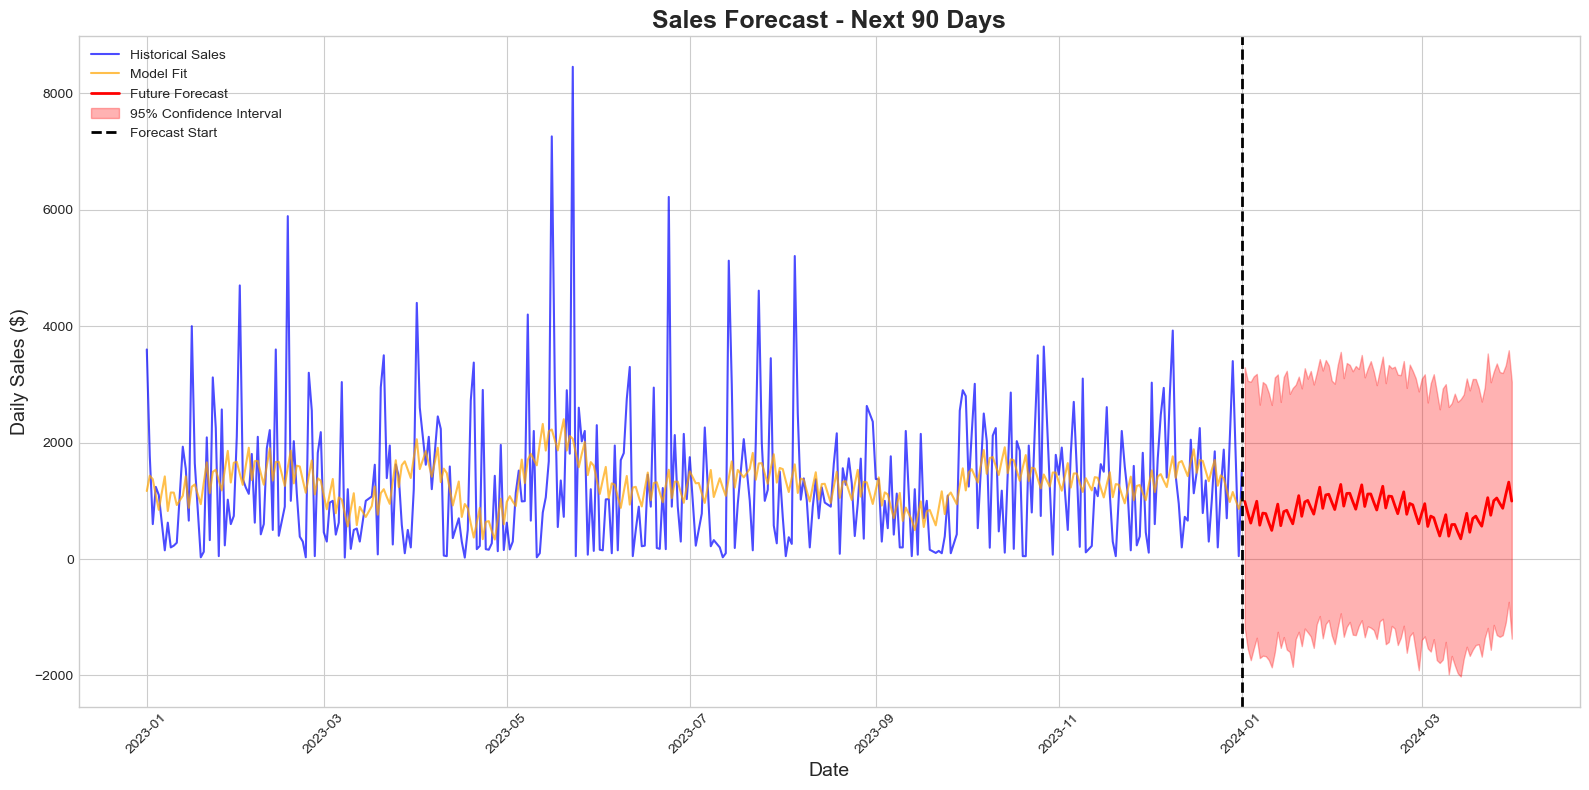

In [36]:
# Visualize Future Forecast

fig = plt.figure(figsize=(16, 8))

# Historical data
plt.plot(prophet_df['ds'], prophet_df['y'], 
         label='Historical Sales', color='blue', alpha=0.7)

# Predicted historical (to show model fit)
historical_predictions = future_forecast[future_forecast['ds'] <= last_date]
plt.plot(historical_predictions['ds'], historical_predictions['yhat'], 
         label='Model Fit', color='orange', alpha=0.7)

# Future forecast
plt.plot(future_only['ds'], future_only['yhat'], 
         label='Future Forecast', color='red', linewidth=2)

# Confidence interval for future
plt.fill_between(future_only['ds'], 
                 future_only['yhat_lower'], 
                 future_only['yhat_upper'],
                 alpha=0.3, color='red', label='95% Confidence Interval')

# Add vertical line separating historical from forecast
plt.axvline(x=last_date, color='black', linestyle='--', linewidth=2, label='Forecast Start')

plt.title(f'Sales Forecast - Next {forecast_days} Days', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Sales ($)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# Summarize forecasts by week and month
future_only['Week'] = future_only['ds'].dt.isocalendar().week
future_only['Month'] = future_only['ds'].dt.month
future_only['MonthName'] = future_only['ds'].dt.month_name()

# Weekly forecast summary
weekly_forecast = future_only.groupby('Week').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum',
    'ds': ['min', 'max']
}).round(2)

weekly_forecast.columns = ['Predicted_Sales', 'Lower_Bound', 'Upper_Bound', 'Week_Start', 'Week_End']
print("\n📊 WEEKLY FORECAST SUMMARY")
print("=" * 80)
print(weekly_forecast.to_string())

# Monthly forecast summary
monthly_forecast = future_only.groupby('MonthName').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'
}).round(2)

monthly_forecast.columns = ['Predicted_Sales', 'Lower_Bound', 'Upper_Bound']
print("\n📊 MONTHLY FORECAST SUMMARY")
print("=" * 60)
print(monthly_forecast.to_string())


📊 WEEKLY FORECAST SUMMARY
      Predicted_Sales  Lower_Bound  Upper_Bound Week_Start   Week_End
Week                                                                 
1             4787.40     -9055.30     18371.41 2024-01-02 2024-01-07
2             4930.41    -11298.93     20530.94 2024-01-08 2024-01-14
3             5651.44    -10460.08     21199.19 2024-01-15 2024-01-21
4             6760.74     -8765.28     22478.47 2024-01-22 2024-01-28
5             7308.75     -8378.30     22826.08 2024-01-29 2024-02-04
6             7352.53     -8392.37     23137.05 2024-02-05 2024-02-11
7             7236.01     -8481.92     22620.27 2024-02-12 2024-02-18
8             6757.09     -9351.20     22582.88 2024-02-19 2024-02-25
9             5553.98    -10325.37     21516.56 2024-02-26 2024-03-03
10            4130.76    -11613.30     20193.58 2024-03-04 2024-03-10
11            3814.30    -12348.96     19790.73 2024-03-11 2024-03-17
12            5266.23    -10268.12     21348.62 2024-03-18 2024

In [38]:
# Generate 30, 60, 90 Day Forecasts

def create_forecast_summary(days):
    """Generate forecast for specified number of days"""
    forecast_subset = future_only.head(days)
    return {
        'Period': f'Next {days} Days',
        'Start_Date': forecast_subset['ds'].min().strftime('%Y-%m-%d'),
        'End_Date': forecast_subset['ds'].max().strftime('%Y-%m-%d'),
        'Total_Predicted': f"${forecast_subset['yhat'].sum():,.2f}",
        'Lower_Bound': f"${forecast_subset['yhat_lower'].sum():,.2f}",
        'Upper_Bound': f"${forecast_subset['yhat_upper'].sum():,.2f}",
        'Daily_Average': f"${forecast_subset['yhat'].mean():,.2f}"
    }

# Create summary for different periods
forecast_summary = pd.DataFrame([
    create_forecast_summary(30),
    create_forecast_summary(60),
    create_forecast_summary(90)
])

print("\n" + "=" * 100)
print("📈 FORECAST SUMMARY FOR DIFFERENT TIME PERIODS")
print("=" * 100)
print(forecast_summary.to_string(index=False))
print("=" * 100)


📈 FORECAST SUMMARY FOR DIFFERENT TIME PERIODS
      Period Start_Date   End_Date Total_Predicted  Lower_Bound Upper_Bound Daily_Average
Next 30 Days 2024-01-02 2024-01-31      $25,322.85  $-43,052.72  $92,391.36       $844.09
Next 60 Days 2024-01-02 2024-03-01      $54,827.22  $-81,646.31 $189,400.11       $913.79
Next 90 Days 2024-01-02 2024-03-31      $76,851.79 $-127,009.33 $279,545.21       $853.91


In [39]:
# Export Clean Dataset

# Export the cleaned daily sales data
daily_sales_export = daily_sales.copy()
daily_sales_export.to_csv('cleaned_daily_sales.csv', index=False)
daily_sales_export.to_excel('cleaned_daily_sales.xlsx', index=False)

print("✅ Exported cleaned daily sales to:")
print("   - cleaned_daily_sales.csv")
print("   - cleaned_daily_sales.xlsx")

✅ Exported cleaned daily sales to:
   - cleaned_daily_sales.csv
   - cleaned_daily_sales.xlsx


In [40]:
# Prepare forecast data for export
forecast_export = future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export.columns = ['Date', 'Predicted_Sales', 'Lower_Bound', 'Upper_Bound']

# Add additional columns for Power BI
forecast_export['Forecast_Type'] = 'Future'
forecast_export['Model'] = 'Prophet'

# Export to CSV and Excel
forecast_export.to_csv('sales_forecast.csv', index=False)
forecast_export.to_excel('sales_forecast.xlsx', index=False)

print("✅ Exported forecast results to:")
print("   - sales_forecast.csv")
print("   - sales_forecast.xlsx")

✅ Exported forecast results to:
   - sales_forecast.csv
   - sales_forecast.xlsx


In [41]:
# Create a combined dataset for Power BI
# Historical data
historical_export = prophet_df.copy()
historical_export.columns = ['Date', 'Actual_Sales']
historical_export['Predicted_Sales'] = np.nan
historical_export['Lower_Bound'] = np.nan
historical_export['Upper_Bound'] = np.nan
historical_export['Data_Type'] = 'Historical'

# Future forecast data
future_export = forecast_export.copy()
future_export['Actual_Sales'] = np.nan
future_export['Data_Type'] = 'Forecast'
future_export = future_export[['Date', 'Actual_Sales', 'Predicted_Sales', 
                               'Lower_Bound', 'Upper_Bound', 'Data_Type']]

# Combine both
combined_export = pd.concat([historical_export, future_export], ignore_index=True)
combined_export = combined_export.sort_values('Date').reset_index(drop=True)

# Export
combined_export.to_csv('combined_sales_data.csv', index=False)
combined_export.to_excel('combined_sales_data.xlsx', index=False)

print("✅ Exported combined data to:")
print("   - combined_sales_data.csv")
print("   - combined_sales_data.xlsx")
print(f"\nTotal rows: {len(combined_export)}")

✅ Exported combined data to:
   - combined_sales_data.csv
   - combined_sales_data.xlsx

Total rows: 435


In [42]:
# Export Model Performance Metrics

metrics_export = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'MAE': [mae, arima_mae],
    'RMSE': [rmse, arima_rmse],
    'MAPE_Percent': [mape, arima_mape],
    'Test_Period_Days': [test_days, test_days],
    'Forecast_Days': [forecast_days, forecast_days]
})

metrics_export.to_csv('model_performance_metrics.csv', index=False)
metrics_export.to_excel('model_performance_metrics.xlsx', index=False)

print("✅ Exported model metrics to:")
print("   - model_performance_metrics.csv")
print("   - model_performance_metrics.xlsx")

print("\n" + "=" * 60)
print("🎉 ALL EXPORTS COMPLETE!")
print("=" * 60)
print("\nFiles created in your current directory:")
print("1. cleaned_daily_sales.csv/xlsx - Your cleaned historical data")
print("2. sales_forecast.csv/xlsx - Future predictions only")
print("3. combined_sales_data.csv/xlsx - Historical + Forecast (for Power BI)")
print("4. model_performance_metrics.csv/xlsx - Model evaluation results")

✅ Exported model metrics to:
   - model_performance_metrics.csv
   - model_performance_metrics.xlsx

🎉 ALL EXPORTS COMPLETE!

Files created in your current directory:
1. cleaned_daily_sales.csv/xlsx - Your cleaned historical data
2. sales_forecast.csv/xlsx - Future predictions only
3. combined_sales_data.csv/xlsx - Historical + Forecast (for Power BI)
4. model_performance_metrics.csv/xlsx - Model evaluation results


In [43]:
# Import Dashboard Libraries

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML

print("✅ Dashboard libraries loaded!")

✅ Dashboard libraries loaded!


In [44]:
# Calculate KPI Metrics

# Historical KPIs
total_sales = daily_sales['Daily_Sales'].sum()
avg_daily_sales = daily_sales['Daily_Sales'].mean()
max_daily_sales = daily_sales['Daily_Sales'].max()
min_daily_sales = daily_sales['Daily_Sales'].min()
total_days = len(daily_sales)

# Forecast KPIs (next 30 days)
forecast_30_days = future_only.head(30)['yhat'].sum()
forecast_60_days = future_only.head(60)['yhat'].sum()
forecast_90_days = future_only.head(90)['yhat'].sum()

# Growth calculation (compare last 30 days actual vs next 30 days forecast)
last_30_actual = daily_sales.tail(30)['Daily_Sales'].sum()
growth_percent = ((forecast_30_days - last_30_actual) / last_30_actual) * 100

print("📊 KPI SUMMARY")
print("=" * 50)
print(f"Total Historical Sales: ${total_sales:,.2f}")
print(f"Average Daily Sales: ${avg_daily_sales:,.2f}")
print(f"Max Daily Sales: ${max_daily_sales:,.2f}")
print(f"Min Daily Sales: ${min_daily_sales:,.2f}")
print(f"30-Day Forecast: ${forecast_30_days:,.2f}")
print(f"Expected Growth: {growth_percent:+.1f}%")
print("=" * 50)

📊 KPI SUMMARY
Total Historical Sales: $456,000.00
Average Daily Sales: $1,321.74
Max Daily Sales: $8,455.00
Min Daily Sales: $25.00
30-Day Forecast: $25,322.85
Expected Growth: -45.1%


In [45]:
# Create KPI Cards Dashboard

def create_kpi_card(value, title, subtitle="", color="#1f77b4"):
    """Create a styled KPI card"""
    return f"""
    <div style="
        background: linear-gradient(135deg, {color}20, {color}05);
        border-left: 4px solid {color};
        border-radius: 8px;
        padding: 20px;
        margin: 10px;
        min-width: 200px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    ">
        <h2 style="margin: 0; color: {color}; font-size: 28px;">{value}</h2>
        <p style="margin: 5px 0 0 0; color: #333; font-weight: bold;">{title}</p>
        <p style="margin: 0; color: #666; font-size: 12px;">{subtitle}</p>
    </div>
    """

# Display KPI Cards
kpi_html = f"""
<div style="display: flex; flex-wrap: wrap; justify-content: space-around; margin: 20px 0;">
    {create_kpi_card(f"${total_sales:,.0f}", "Total Historical Sales", f"Over {total_days} days", "#2ecc71")}
    {create_kpi_card(f"${avg_daily_sales:,.0f}", "Avg Daily Sales", "Historical average", "#3498db")}
    {create_kpi_card(f"${forecast_30_days:,.0f}", "30-Day Forecast", "Expected revenue", "#9b59b6")}
    {create_kpi_card(f"{growth_percent:+.1f}%", "Expected Growth", "vs Last 30 Days", "#e74c3c" if growth_percent < 0 else "#2ecc71")}
</div>
"""

display(HTML(kpi_html))

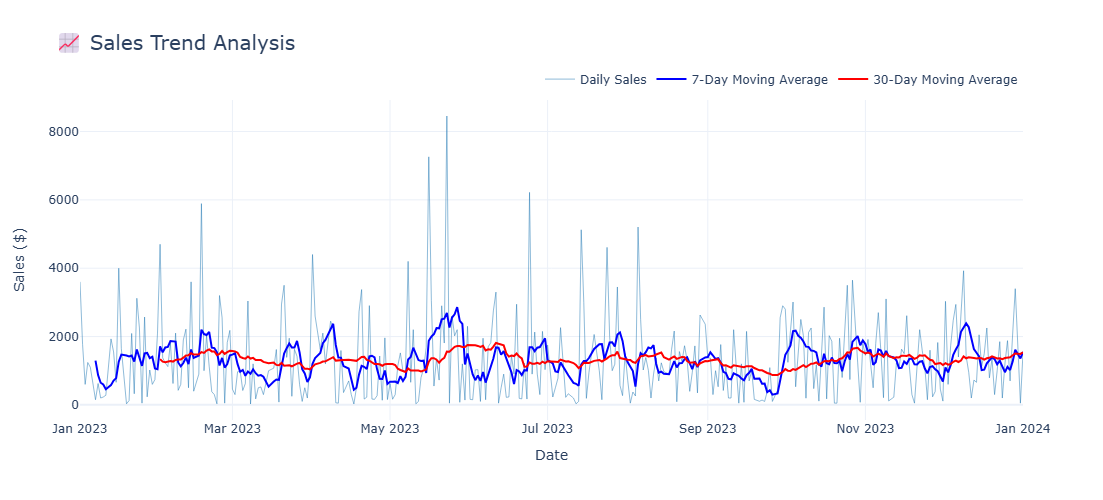

In [57]:
# Interactive Sales Trend Chart

fig_trend = go.Figure()

# Historical sales
fig_trend.add_trace(go.Scatter(
    x=daily_sales['Date'],
    y=daily_sales['Daily_Sales'],
    name='Daily Sales',
    line=dict(color='rgba(31, 119, 180, 0.5)', width=1),
    mode='lines'
))

# 7-day moving average
fig_trend.add_trace(go.Scatter(
    x=daily_sales['Date'],
    y=daily_sales['MA_7'],
    name='7-Day Moving Average',
    line=dict(color='blue', width=2)
))

# 30-day moving average
fig_trend.add_trace(go.Scatter(
    x=daily_sales['Date'],
    y=daily_sales['MA_30'],
    name='30-Day Moving Average',
    line=dict(color='red', width=2)
))

fig_trend.update_layout(
    title=dict(text='📈 Sales Trend Analysis', font=dict(size=20)),
    xaxis_title='Date',
    yaxis_title='Sales ($)',
    template='plotly_white',
    hovermode='x unified',
    height=500,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig_trend.show()

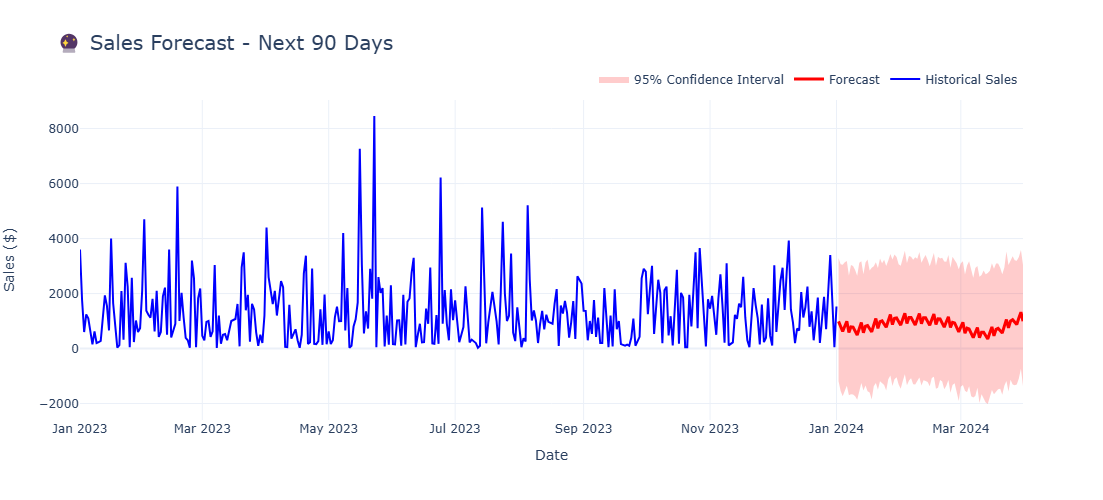

In [56]:
# Interactive Forecast Chart

fig_forecast = go.Figure()

# Historical data
fig_forecast.add_trace(go.Scatter(
    x=prophet_df['ds'],
    y=prophet_df['y'],
    name='Historical Sales',
    line=dict(color='blue', width=2),
    mode='lines'
))

# Future forecast
fig_forecast.add_trace(go.Scatter(
    x=future_only['ds'],
    y=future_only['yhat'],
    name='Forecast',
    line=dict(color='red', width=3),
    mode='lines'
))

# Confidence interval (upper)
fig_forecast.add_trace(go.Scatter(
    x=future_only['ds'],
    y=future_only['yhat_upper'],
    name='Upper Bound',
    line=dict(color='rgba(255,0,0,0)', width=0),
    mode='lines',
    showlegend=False
))

# Confidence interval (lower) with fill
fig_forecast.add_trace(go.Scatter(
    x=future_only['ds'],
    y=future_only['yhat_lower'],
    name='95% Confidence Interval',
    line=dict(color='rgba(255,0,0,0)', width=0),
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255,0,0,0.2)'
))


fig_forecast.update_layout(
    title=dict(text='🔮 Sales Forecast - Next 90 Days', font=dict(size=20)),
    xaxis_title='Date',
    yaxis_title='Sales ($)',
    template='plotly_white',
    hovermode='x unified',
    height=500,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig_forecast.show()

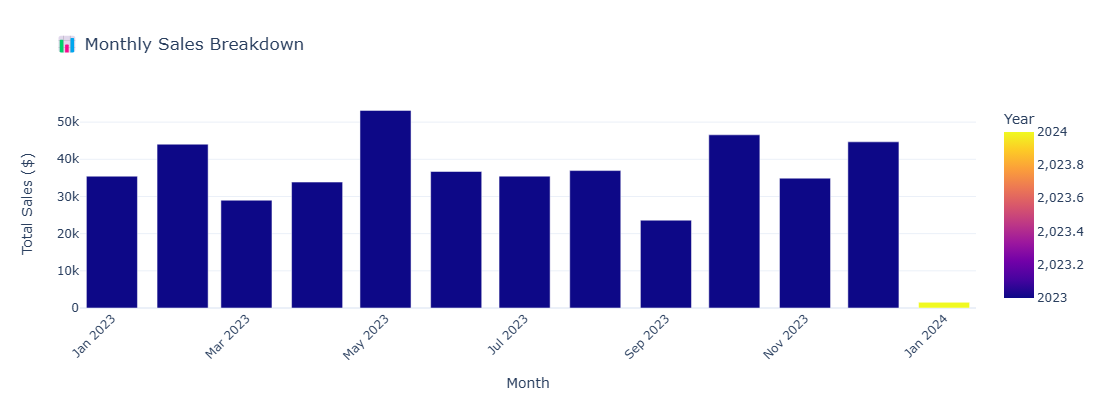

In [58]:
# Monthly Sales Breakdown Chart

# Calculate monthly sales
monthly_data = df.groupby(['Year', 'Month', 'MonthName'])['Total Amount'].sum().reset_index()
monthly_data['YearMonth'] = monthly_data['Year'].astype(str) + '-' + monthly_data['Month'].astype(str).str.zfill(2)

fig_monthly = px.bar(
    monthly_data,
    x='YearMonth',
    y='Total Amount',
    color='Year',
    title='📊 Monthly Sales Breakdown',
    labels={'Total Amount': 'Total Sales ($)', 'YearMonth': 'Month'},
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig_monthly.update_layout(
    template='plotly_white',
    height=400,
    showlegend=True,
    xaxis_tickangle=-45
)

fig_monthly.show()


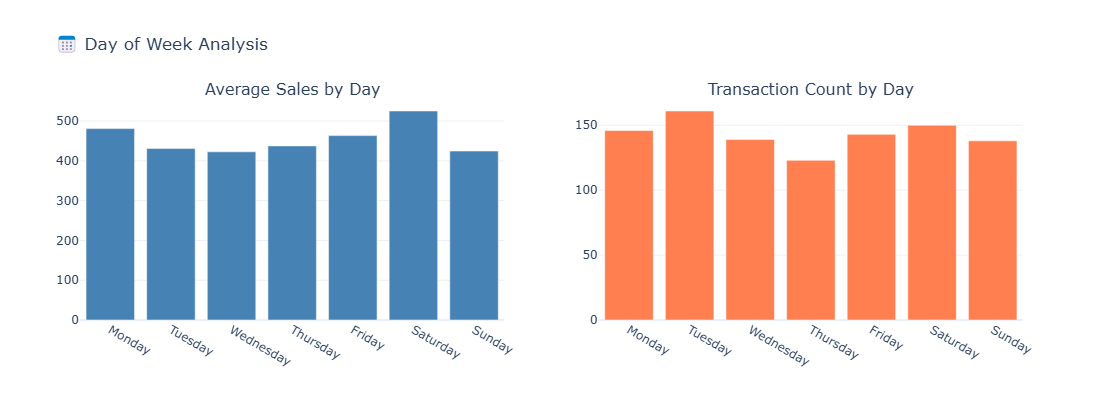

In [59]:
# Day of Week Analysis (Interactive)

dow_data = df.groupby(['DayName', 'DayOfWeek'])['Total Amount'].agg(['sum', 'mean', 'count']).reset_index()
dow_data.columns = ['DayName', 'DayOfWeek', 'Total_Sales', 'Avg_Sales', 'Transaction_Count']
dow_data = dow_data.sort_values('DayOfWeek')

fig_dow = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Average Sales by Day', 'Transaction Count by Day'),
    specs=[[{"type": "bar"}, {"type": "bar"}]]
)

fig_dow.add_trace(
    go.Bar(x=dow_data['DayName'], y=dow_data['Avg_Sales'], name='Avg Sales',
           marker_color='steelblue'),
    row=1, col=1
)

fig_dow.add_trace(
    go.Bar(x=dow_data['DayName'], y=dow_data['Transaction_Count'], name='Transactions',
           marker_color='coral'),
    row=1, col=2
)

fig_dow.update_layout(
    title_text='📅 Day of Week Analysis',
    template='plotly_white',
    height=400,
    showlegend=False
)

fig_dow.show()

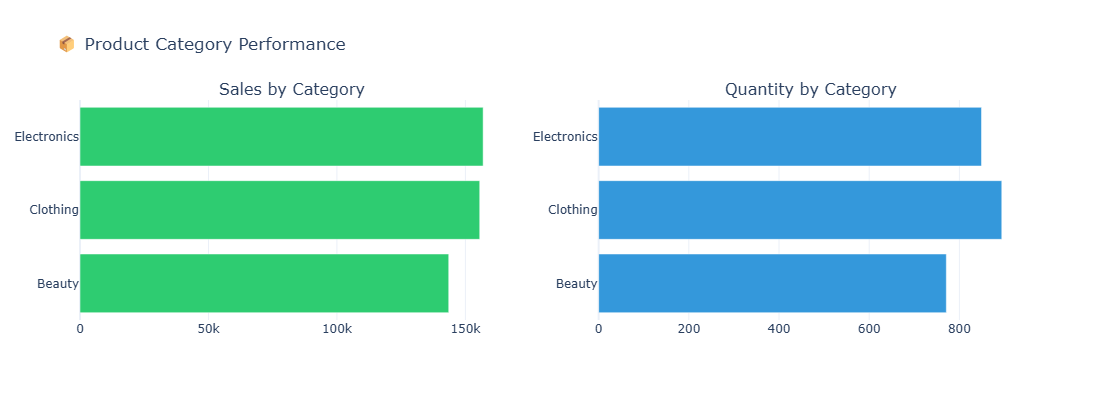

In [60]:
# Product Category Analysis (Interactive)

category_data = df.groupby('Product Category').agg({
    'Total Amount': 'sum',
    'Quantity': 'sum'
}).reset_index().sort_values('Total Amount', ascending=True)

fig_category = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Sales by Category', 'Quantity by Category'),
    specs=[[{"type": "bar"}, {"type": "bar"}]]
)

fig_category.add_trace(
    go.Bar(y=category_data['Product Category'], x=category_data['Total Amount'],
           orientation='h', name='Sales', marker_color='#2ecc71'),
    row=1, col=1
)

fig_category.add_trace(
    go.Bar(y=category_data['Product Category'], x=category_data['Quantity'],
           orientation='h', name='Quantity', marker_color='#3498db'),
    row=1, col=2
)

fig_category.update_layout(
    title_text='📦 Product Category Performance',
    template='plotly_white',
    height=400,
    showlegend=False
)

fig_category.show()

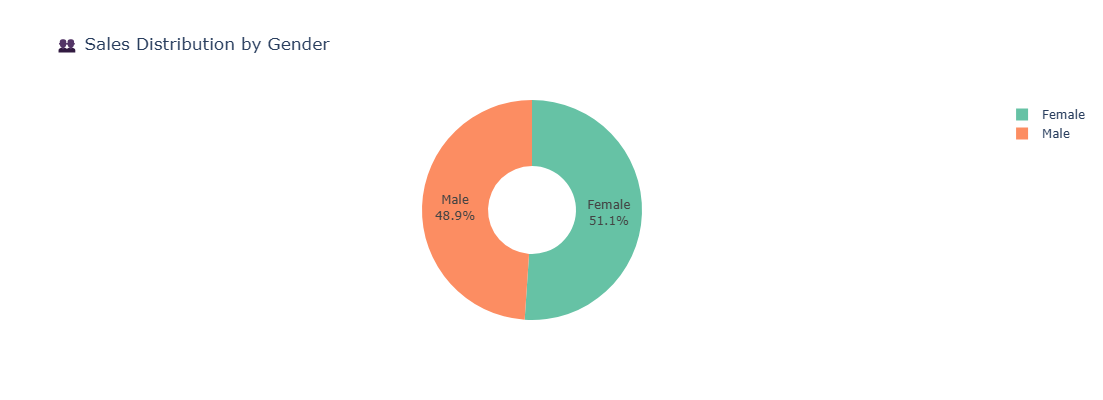

In [61]:
# Gender Distribution (Interactive Pie Chart)

gender_data = df.groupby('Gender')['Total Amount'].sum().reset_index()

fig_gender = px.pie(
    gender_data,
    values='Total Amount',
    names='Gender',
    title='👥 Sales Distribution by Gender',
    color_discrete_sequence=px.colors.qualitative.Set2,
    hole=0.4  # Makes it a donut chart
)

fig_gender.update_traces(
    textposition='inside',
    textinfo='percent+label',
    hovertemplate='%{label}<br>Sales: $%{value:,.2f}<br>Percentage: %{percent}'
)

fig_gender.update_layout(
    template='plotly_white',
    height=400
)

fig_gender.show()

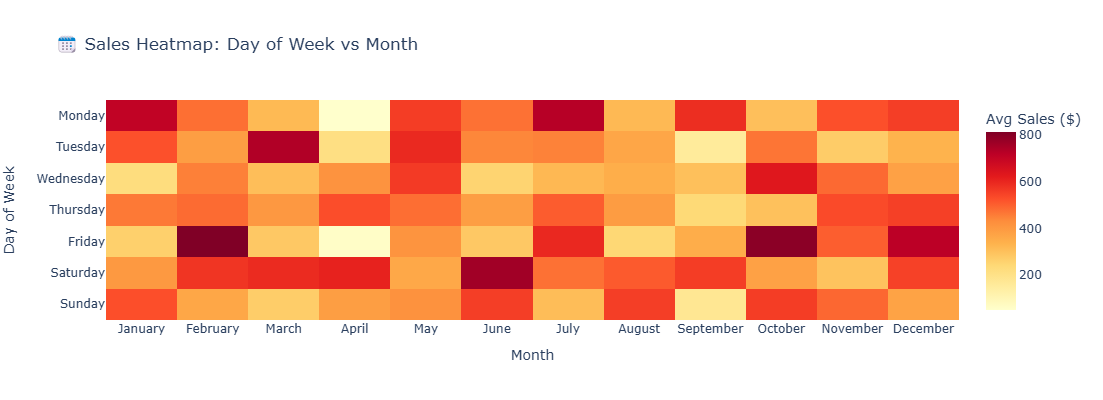

In [62]:
# Interactive Heatmap


# Create pivot table for heatmap
heatmap_df = df.pivot_table(
    values='Total Amount',
    index='DayName',
    columns='MonthName',
    aggfunc='mean'
)

# Reorder
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
existing_months = [m for m in month_order if m in heatmap_df.columns]
heatmap_df = heatmap_df.reindex(index=day_order, columns=existing_months)

fig_heatmap = px.imshow(
    heatmap_df,
    title='🗓️ Sales Heatmap: Day of Week vs Month',
    labels=dict(x="Month", y="Day of Week", color="Avg Sales ($)"),
    color_continuous_scale='YlOrRd',
    aspect='auto'
)

fig_heatmap.update_layout(
    template='plotly_white',
    height=400
)

fig_heatmap.show()

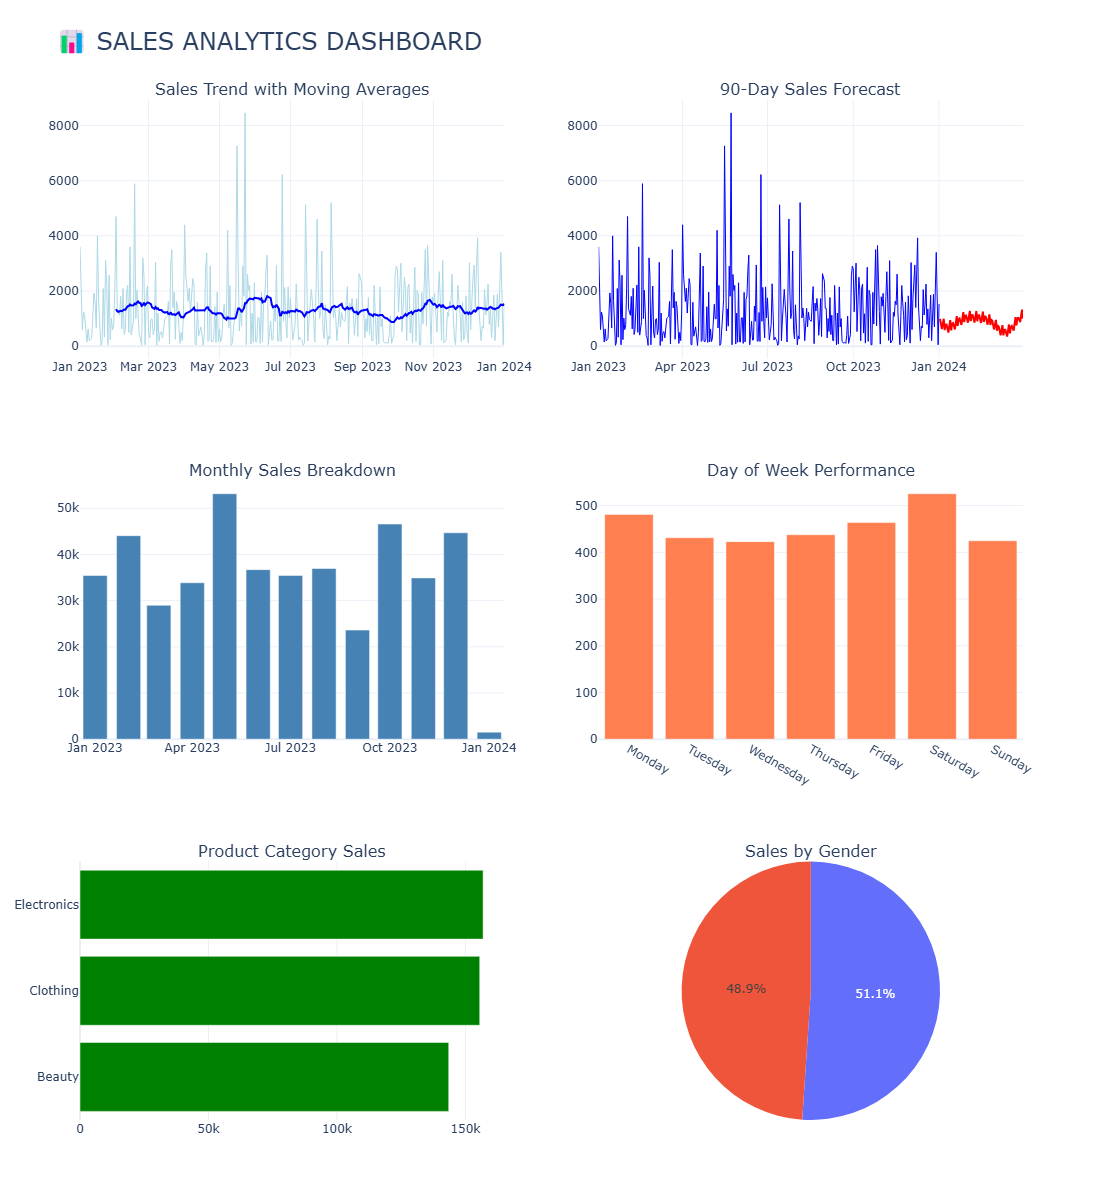


✅ Dashboard created successfully!
💡 Tip: You can zoom, pan, and hover over charts for more details!


In [63]:
# Complete Dashboard Layout

def create_complete_dashboard():
    """Create a comprehensive dashboard with all visualizations"""
    
    # Create figure with subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Sales Trend with Moving Averages',
            '90-Day Sales Forecast',
            'Monthly Sales Breakdown',
            'Day of Week Performance',
            'Product Category Sales',
            'Sales by Gender'
        ),
        specs=[
            [{"type": "scatter"}, {"type": "scatter"}],
            [{"type": "bar"}, {"type": "bar"}],
            [{"type": "bar"}, {"type": "pie"}]
        ],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # Row 1, Col 1: Sales Trend
    fig.add_trace(
        go.Scatter(x=daily_sales['Date'], y=daily_sales['Daily_Sales'],
                   name='Daily Sales', line=dict(color='lightblue', width=1)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=daily_sales['Date'], y=daily_sales['MA_30'],
                   name='30-Day MA', line=dict(color='blue', width=2)),
        row=1, col=1
    )
    
    # Row 1, Col 2: Forecast
    fig.add_trace(
        go.Scatter(x=prophet_df['ds'], y=prophet_df['y'],
                   name='Historical', line=dict(color='blue', width=1)),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=future_only['ds'], y=future_only['yhat'],
                   name='Forecast', line=dict(color='red', width=2)),
        row=1, col=2
    )
    
    # Row 2, Col 1: Monthly
    fig.add_trace(
        go.Bar(x=monthly_data['YearMonth'], y=monthly_data['Total Amount'],
               name='Monthly Sales', marker_color='steelblue'),
        row=2, col=1
    )
    
    # Row 2, Col 2: Day of Week
    fig.add_trace(
        go.Bar(x=dow_data['DayName'], y=dow_data['Avg_Sales'],
               name='Avg by Day', marker_color='coral'),
        row=2, col=2
    )
    
    # Row 3, Col 1: Category
    fig.add_trace(
        go.Bar(y=category_data['Product Category'], x=category_data['Total Amount'],
               orientation='h', name='By Category', marker_color='green'),
        row=3, col=1
    )
    
    # Row 3, Col 2: Gender (as pie)
    fig.add_trace(
        go.Pie(labels=gender_data['Gender'], values=gender_data['Total Amount'],
               name='By Gender'),
        row=3, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=1200,
        width=1400,
        title_text='📊 SALES ANALYTICS DASHBOARD',
        title_font_size=24,
        showlegend=False,
        template='plotly_white'
    )
    
    return fig

# Display the complete dashboard
dashboard = create_complete_dashboard()
dashboard.show()

print("\n✅ Dashboard created successfully!")
print("💡 Tip: You can zoom, pan, and hover over charts for more details!")


In [64]:
# Export Dashboard to HTML

# Save individual charts
fig_trend.write_html('chart_sales_trend.html')
fig_forecast.write_html('chart_forecast.html')
fig_monthly.write_html('chart_monthly.html')
dashboard.write_html('complete_dashboard.html')

print("✅ Dashboard exported to HTML files!")
print("\nFiles created:")
print("- chart_sales_trend.html")
print("- chart_forecast.html")
print("- chart_monthly.html")
print("- complete_dashboard.html (Full dashboard)")
print("\n💡 Double-click any HTML file to open in your browser!")

✅ Dashboard exported to HTML files!

Files created:
- chart_sales_trend.html
- chart_forecast.html
- chart_monthly.html
- complete_dashboard.html (Full dashboard)

💡 Double-click any HTML file to open in your browser!
